In [1]:
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from scipy.optimize import fmin_l_bfgs_b

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K

config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

Using TensorFlow backend.


In this script, we will focus on generating an image
that attempts to match the content of one input image
and the style of another input image.

We accomplish this by balancing the content loss
and style loss simultaneously.

In [2]:
def VGG16_AvgPool(shape):
    # we want to account for features across the entrie image
    # so we get rid of the maxpool which throws away information
    vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)
    
    new_model = Sequential()
    for layer in vgg.layers:
        if layer.__class__ == MaxPooling2D:
            # replace it with average pooling
            new_model.add(AveragePooling2D())
        else:
            new_model.add(layer)
    return new_model

In [3]:
def unpreprocess(img):
    # un-preprocess image from keras vgg which subtract mean
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 126.68
    img = img[..., ::-1]
    return img

def scale_img(x):
    x = x - x.min()
    x = x / x.max()
    return x

In [4]:
def gram_matrix(img):
    # input is (H, W, C) (C = # features)
    # we first need to convert it to (C, H*W)
    X = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))
    # calculate the gram matrix
    # gram = XX^T / N
    # the constant is not important since we'll be weighting these
    G = K.dot(X, K.transpose(X)) / img.get_shape().num_elements()
    return G

In [5]:
def style_loss(y, t):
    return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))

In [6]:
def minimize(fn, epochs, batch_shape):
    losses = []
    x = np.random.randn(np.prod(batch_shape))
    for i in range(epochs):
        x, l, _ = fmin_l_bfgs_b(
            func=fn,
            x0=x,
            maxfun=20
        )
        x = np.clip(x, -127, 127)
        print("iter=", i, ',', 'loss=', l)
        losses.append(l)
        
    plt.plot(losses)
    
    newimg = x.reshape(*batch_shape)
    final_img = unpreprocess(newimg)
    return final_img[0]

In [7]:
# load the content image
def load_img_and_preprocess(path, shape=None):
    img = image.load_img(path, target_size=shape)
    
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [8]:
content_img = load_img_and_preprocess('./data/content/sydney.jpg')

In [9]:
# resize the style image, since we don't cate too much about warping it
h, w = content_img.shape[1:3]
style_img = load_img_and_preprocess('./data/styles/lesdemoisellesdavignon.jpg', (h, w))

In [10]:
batch_shape = content_img.shape
shape = content_img.shape[1:]

In [11]:
# we want to make only 1 VGG here
# as you'll see later, the final model needs
# to have a common input
vgg = VGG16_AvgPool(shape)

In [13]:
print(vgg.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 397, 635, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 397, 635, 64)      36928     
_________________________________________________________________
average_pooling2d_1 (Average (None, 198, 317, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 198, 317, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 198, 317, 128)     147584    
_________________________________________________________________
average_pooling2d_2 (Average (None, 99, 158, 128)      0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 99, 158, 256)      295168    
__________

In [14]:
# create the content model
# we only want 1 output
# remember you can call vgg.summary() to see a list of layers
# 1,2,4,5,7-9,11-13,15-17
content_model = Model(vgg.input, vgg.layers[13].get_output_at(0))
content_target = K.variable(content_model.predict(content_img))

In [15]:
# create the style model
# we want multiple outputs
# we will take the same approach as in style_transfer2.py
symbolic_conv_outputs = [
    layer.get_output_at(1) for layer in vgg.layers \
    if layer.name.endswith('conv1')
]

In [28]:
# make a big model that outputs multiple layers' outputs
style_model = Model(vgg.input, symbolic_conv_outputs)

# calculate the targets that are output at each layer
style_layers_outputs = [K.variable(y) for y in style_model.predict(style_img)]

# we will assume the weight of the content loss is 1
# and only weight the style losses
style_weights = [0.2,0.4,0.3,0.5,0.2]

In [29]:
# create the total loss which is the sum of content + style loss
loss = K.mean(K.square(content_model.output - content_target))

for w, symbolic, actual in zip(style_weights, symbolic_conv_outputs, style_layers_outputs):
    # gram_matrix() expects a (H, W, C) as input
    loss += w * style_loss(symbolic[0], actual[0])

iter= 0 , loss= 4288.40380859375
iter= 1 , loss= 1003.7039184570312
iter= 2 , loss= 596.5120849609375
iter= 3 , loss= 442.16619873046875
iter= 4 , loss= 366.1819152832031
iter= 5 , loss= 324.51861572265625
iter= 6 , loss= 293.60107421875
iter= 7 , loss= 272.0965576171875
iter= 8 , loss= 251.87049865722656
iter= 9 , loss= 237.55307006835938


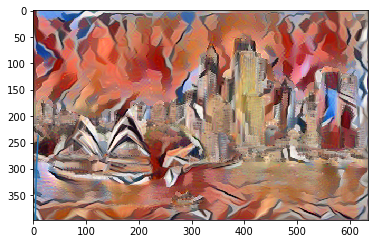

In [30]:
# once again, create the gradients and loss + grads function
# note: it doesn't matter which model's input you use
# they are both pointing to the same keras Input layer in memory
grads = K.gradients(loss, vgg.input)

# just like theano.function
get_loss_and_grads = K.function(
    inputs=[vgg.input],
    outputs=[loss] + grads
)


def get_loss_and_grads_wrapper(x_vec):
    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)


final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape)
plt.imshow(scale_img(final_img))
